<a href="https://colab.research.google.com/github/JuanSpecht/PDI2021/blob/main/TP2/PDI_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera parte: Luminancia y saturación

## Instalo los paquetes necesarios

In [ ]:
!pip install "cmocean[plots]" # para acceder al mapa de color topográfico 'cmo.topo'
!pip install matplotlib==3.4.3 # versiones anteriores no tienen mcolors.CenteredNorm()

## Importo las bibliotecas necesarias

In [53]:
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import imageio as io
import cmocean

## Definición de funciones

In [44]:
# Para cargar las imágenes
def load_image (path):
  reader = io.get_reader(path)
  img = reader.get_data(0)
  return reader, img

# Para extraer información básica de la imagen
def image_info (reader):
  height, width, channels = reader.get_data(0).shape

  print ('La imagen está en formato ' + str(reader.format.plugin_id) +
       ', sus dimensiones son: ' + str(width) + ' px horizontales y ' +
       str(height) + ' px verticales. El archivo está compuesto de ' + 
       str(channels) + ' canales.')
  
# Para graficar la imagen
def plot_image(img, title=None, cmap=None):
  fig, ax = plt.subplots(dpi=100)
  ax.imshow(img, cmap=cmap)
  ax.set_title(title)
  plt.axis('off')
  plt.show()

# Para modificar la luminancia y saturación de una imagen
def yiq_controller(img_rgb, luma_factor, sat_factor):
  
  '''img_yiq: imagen en modo YIQ 
  luma_factor: factor multiplicativo para la luinancia
  sat_factor: factor multiplicativo para la saturación'''
  
  # Defino las matrices de transformación RGB->YIQ y YIQ->RGB
  rgb2yiq = np.array([[0.299, 0.587, 0.114],[0.595716, -0.274453, -0.321263],[0.211456, -0.522591, 0.311135]])
  yiq2rgb = np.array([[1, 0.9663, 0.6210], [1, -0.2721, -0.6474], [1, -1.1070, 1.7046]])

  # Normalizo la matriz de la imagen a valores en el interalo [0,1]
  img_rgb_normal = img_rgb/255

  # Transformo la imagen RGB a YIQ
  img_yiq = np.einsum('kl,ijl->ijk', rgb2yiq, img_rgb_normal)

  # Multiplico la luminancia y la saturación por sendos factores
  img_yiq_new = img_yiq[:,:,0:3] * [luma_factor, sat_factor, sat_factor]

  # Limito los valores de luminancia y saturación
  img_yiq_new[:,:,0] = np.clip(img_yiq_new[:,:,0], 0, 1)
  img_yiq_new[:,:,1] = np.clip(img_yiq_new[:,:,1], -0.5957, 0.5957)
  img_yiq_new[:,:,2] = np.clip(img_yiq_new[:,:,2], -0.5226, 0.5226)

  # Transformo la imagen de YIQ a RGB
  img_rgb_normal_new = np.einsum('kl,ijl->ijk', yiq2rgb, img_yiq_new)

  # Limito los valores de los canales R, G y B normalizados
  img_rgb_normal_new[:,:,0] = np.clip(img_rgb_normal_new[:,:,0], 0, 1)
  img_rgb_normal_new[:,:,1] = np.clip(img_rgb_normal_new[:,:,1], 0, 1)
  img_rgb_normal_new[:,:,2] = np.clip(img_rgb_normal_new[:,:,2], 0, 1)

  # Convierto a bytes y redondeo a enteros
  img_rgb_new = img_rgb_normal_new * 255 
  img_rgb_new = np.rint(img_rgb_new).astype(np.uint8) 

  return img_rgb_new

# Para graficar eligiendo el mapa de color
def plot_choose_cmap (img, cmap):
  fig, ax = plt.subplots(dpi = 150)
  plt.axis('off')

  # Si se usa el mapa topográfico hay que centrarlo 
  if cmap == 'cmo.topo':
    im = plt.imshow(img, norm=mcolors.CenteredNorm(), cmap = cmap);
  else:
    im = plt.imshow(img, cmap = cmap);
      
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='3%', pad=0.04)
  cbar = fig.colorbar(im, cax=cax, orientation='vertical')
  cbar.ax.tick_params(labelsize=7) 

  plt.show()

## Cargo la imagen y extraigo su información básica

La imagen está en formato JPEG, sus dimensiones son: 940 px horizontales y 625 px verticales. El archivo está compuesto de 3 canales.


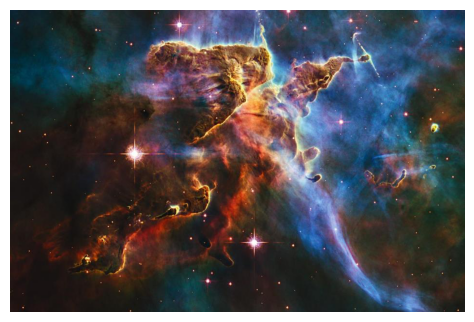

In [57]:
urllib.request.urlretrieve(
  'https://raw.githubusercontent.com/JuanSpecht/PDI2021/main/TP2/CarinaNebula.jpg',
   "img.jpg")
reader, img = load_image('img.jpg')
image_info (reader)
plot_image(img)

## Interactivo para visualizar la imagen variando la luminancia y la saturación

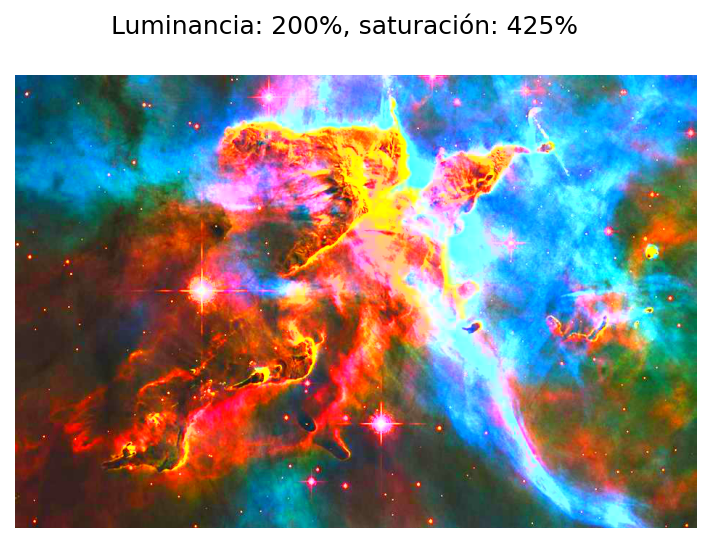

In [4]:
#@title Control interactivo de luminancia y saturación { run: "auto" }

luma_factor = 2 #@param {type:"slider", min:0, max:2, step:0.05}
sat_factor = 4.25 #@param {type:"slider", min:0, max:5, step:0.05}

img_rgb_new = yiq_controller(img, luma_factor, sat_factor)

fig = plt.figure(dpi=150)
fig.suptitle ('Luminancia: ' + np.str(int(luma_factor*100)) +
              '%, saturación: ' + np.str(int(sat_factor*100)) + '%')
plt.imshow(img_rgb_new)
plt.axis('off');

## Comparación de tres valores de saturación


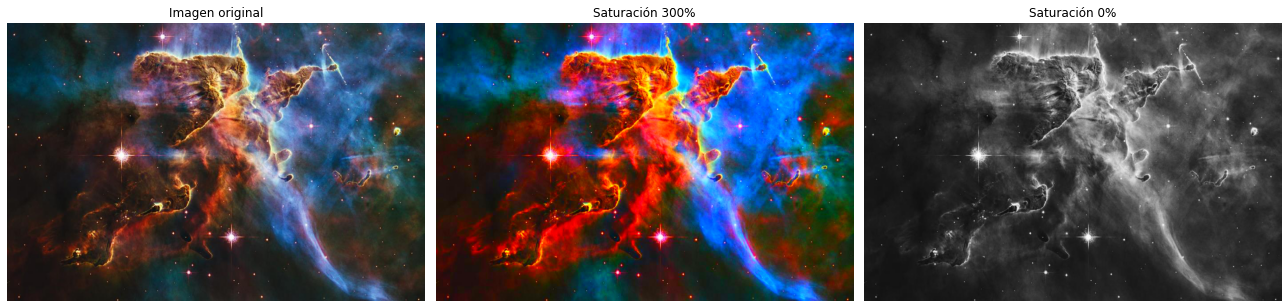

In [5]:
fig, axs = plt.subplots(1,3, figsize= (18,5))

img_rgb_new = yiq_controller(img, 1, 1)
img_0 = axs[0].imshow(img_rgb_new)
axs[0].axis('off')
axs[0].title.set_text('Imagen original')

img_rgb_new = yiq_controller(img, 1, 3)
img_1 = axs[1].imshow(img_rgb_new)
axs[1].axis('off')
axs[1].title.set_text('Saturación 300%')

img_rgb_new = yiq_controller(img, 1, 0)
img_2 = axs[2].imshow(img_rgb_new)
axs[2].axis('off')
axs[2].title.set_text('Saturación 0%')

fig.tight_layout()
plt.show()

### Saturación al 300%:

* Se puede ver que cuando elevamos la saturación al 300% se pierde parte de la información visual, algunos detalles de la imagen dejan de ser evidentes, sobre todo en las regiones donde predomina alguno de los tres canales (por ejemplo en el centro donde predomina el rojo, o en la parte superior derecha donde predomina el azul)

* Por otro lado, al aumentar la saturación también se hace más visible la información de cromaticidad en algunas regiones. Por ejemplo, donde la imagen original es casi blanca, al aumentar la saturación se ve que en realidad hay un ligero tinte de algún color en particular

### Saturación al 0%:

* En la imagen con 0% de saturación se pierde la información relacionada con la cromaticidad, como los cambios de color que hay en la periferia de la imagen

* Pero por otro lado en dicha imagen todavía se puede apreciar la información relacionada con la luminancia. Por ejemplo los puntos resplandecientes o los contrastes de luminancia en el centro de la imagen.

## Comparación de tres valores de luminancia

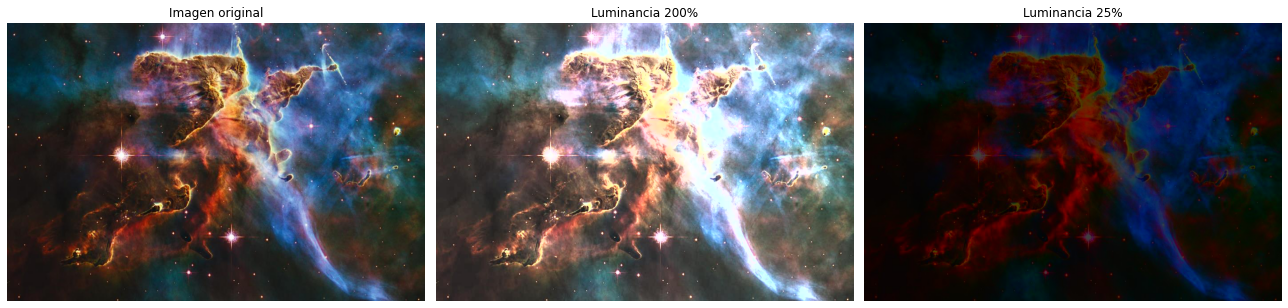

In [6]:
fig, axs = plt.subplots(1,3, figsize= (18,5))

img_rgb_new = yiq_controller(img, 1, 1)
img_0 = axs[0].imshow(img_rgb_new)
axs[0].axis('off')
axs[0].title.set_text('Imagen original')

img_rgb_new = yiq_controller(img, 2, 1)
img_1 = axs[1].imshow(img_rgb_new)
axs[1].axis('off')
axs[1].title.set_text('Luminancia 200%')

img_rgb_new = yiq_controller(img, 0.25, 1)
img_2 = axs[2].imshow(img_rgb_new)
axs[2].axis('off')
axs[2].title.set_text('Luminancia 25%')

fig.tight_layout()
plt.show()

### Luminancia al 200%:

* Al elevar tanto la luminancia cuesta identificar el color de las regiones más luminosas, que se ven prácticamente blancas

### Luminancia al 25%:

* Al disminuir la luminancia al 25% sucede algo parecido pero con las zonas más oscuras de la imagen, donde sedificulta distinguir los detalles

# Segunda parte: mapas cromáticos

## Cargo el dataset
El dataset utilizado es un mapa topobatimétrico (elevación del terreno y profundidad del lecho marino) en formato .tiff

In [64]:
urllib.request.urlretrieve(
  'https://raw.githubusercontent.com/JuanSpecht/PDI2021/main/TP2/alwdgg.tif',
   "img2.tif")
reader2, img2 = load_image('alwdgg.tif')

## Interactivo para visualizar el dataset con diferenes mapas de color

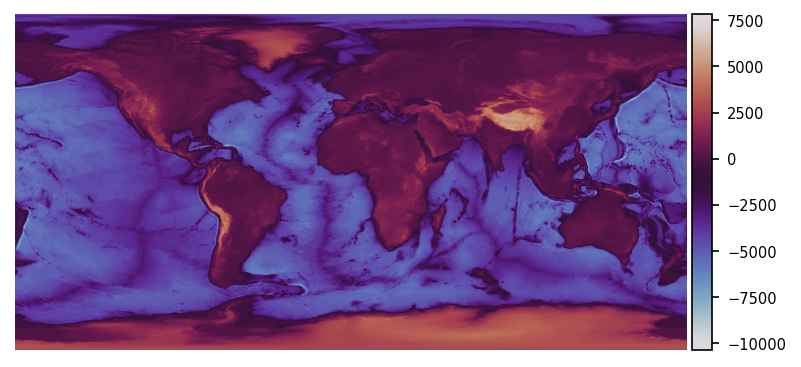

In [71]:
#@title Colormap chooser { run : "auto" }
colormap = "twilight" #@param ["rainbow", "gray", "binary", "prism", "twilight", "cmo.topo", "terrain"]
plot_choose_cmap(img2, colormap)

## Comparo diferentes mapas cromáticos




### Mapa de color `cmo.topo` del paquete `cmocean`

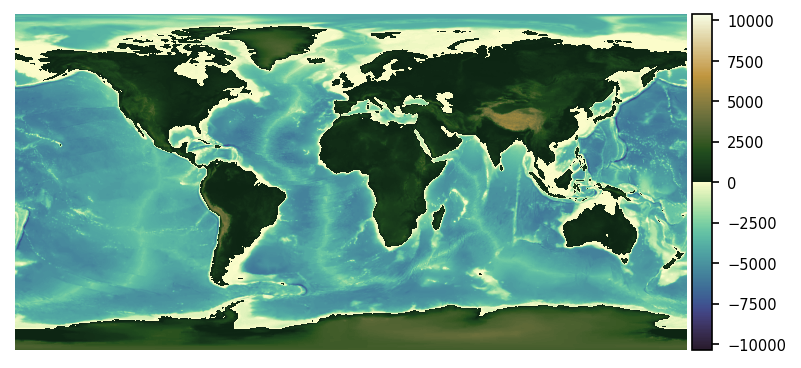

In [48]:
plot_choose_cmap(img2, 'cmo.topo')

* cmo.topo emula los colores que estamos acostumbrados a ver en mapas de la Tierra
* Para valores negativos de los datos la luminancia aumenta hasta llegar a su máximo en 0, allí cambia de manera discontinua y vuelve a subir de manera continua.
* Al utilizar este mapa de color fue necesario centrarlo en 0, con el fin de que la discontinuidad se de a la altura 0
* La principal ventaja es que permite distinguir claramente los continentes del lecho marino



### Escala de grises, mapa de color `gray`

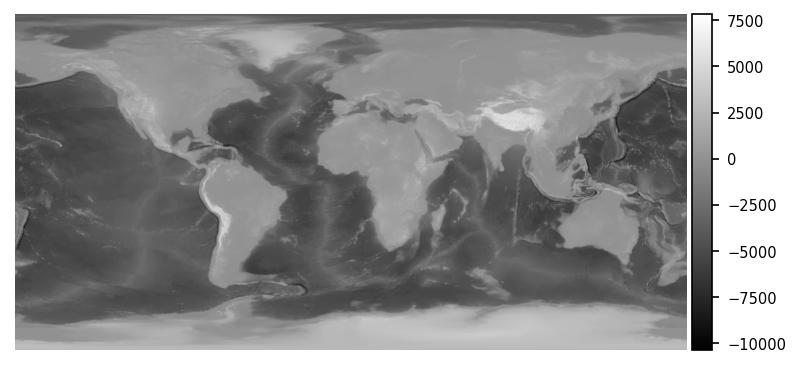

In [47]:
plot_choose_cmap(img2, 'gray')

* Con este mapa de color se representan los valores del dataset mediante la luminancia únicamente, sin cambios de cromaticidad, por lo tanto la imagen se ve en escala de grises.

* A diferencia del mapa de color anterior, donde había un corte en 0, con este se perciben más difusas las costas donde la plataforma continental es ancha. Ejemplo de esto es la costa argentina, donde la plataforma continental llega hasta las Islas Malvinas; o el norte de Europa, donde las islas del Reino Unido parecen estar unidas al continente.

### Mapa de color `rainbow`

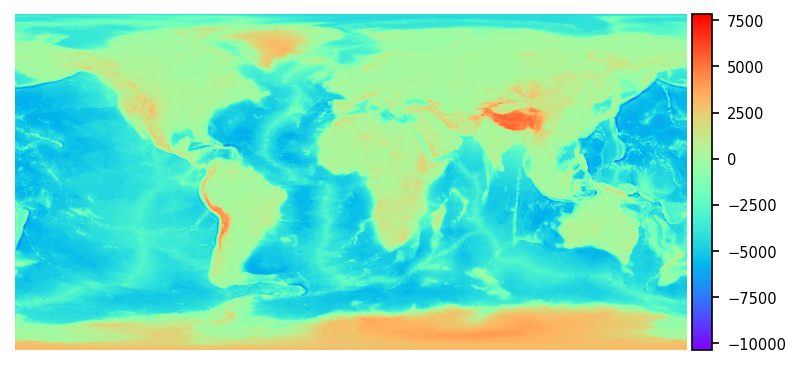

In [46]:
plot_choose_cmap(img2, 'rainbow')

* En este mapa de color los valores se codifican con un cambio en la cromaticidad en lugar de la luminancia

* Se ve mucho más saturado que los dos anteriores, y no se distinguen muchos detalles en las regiones continentales, excepto por los puntos más altos, donde el mapa de color usa el rojo que contrasta con el cian de alrededor (p.ej: los Himalayas, la Cordillera de los Andes)

## Mapa de color `prism`

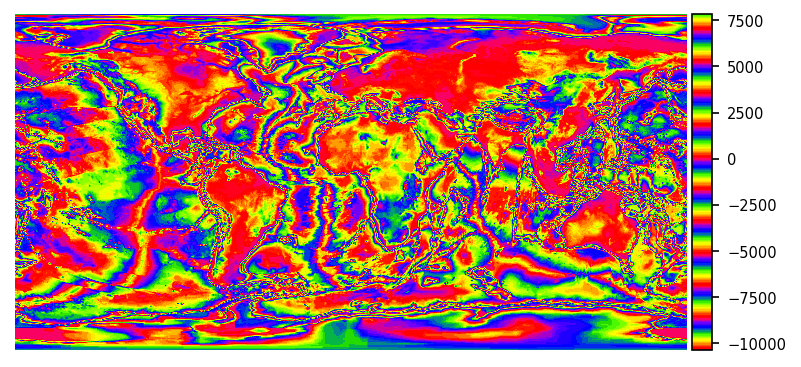

In [45]:
plot_choose_cmap(img2, 'prism')

* En este mapa de color varía la cromaticidad de forma periódica, y con una frecuencia más alta que en los casos anteriores. Esto genera que macroscópicamente no sea muy claro, pero hay más precisión en los detalles.

  Por ejemplo los montes Urales, que son bastante bajos y angostos, llegan a apreciarse bien con este mapa de color, a diferencia de los anteriores. Esto se debe a que la alta frecuencia en los cambios de cromaticidad permite tener un color bien distinto dentro de los Urales comparado con sus alrededores.